...

In [1]:
from torchvision import datasets, transforms
import torch
from torch import nn
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

In [2]:
batch_size = 1
device = "cuda"
print(torch.cuda.is_available())

True


#### Instanciamos la red para generar los embeddings

In [3]:

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        ) 

    def forward(self, x):
        x = self.flatten(x)
        embedding = self.linear_relu_stack[:-1](x)  
        logits = self.linear_relu_stack(x)
        return embedding, logits

In [19]:
# [(num+15, train_data[i][1]) for num, i in enumerate(range(15, 40))]

#### Generamos el clasificador con los pesos malos

In [4]:
from pprint import pprint
estado_fase_0 = torch.load('Fase_0.pth')
estado_fase_1 = torch.load('Fase_1.pth')

estado_fase_1["linear_relu_stack.4.weight"][5:10, :] = estado_fase_0["linear_relu_stack.4.weight"][5:10, :]
estado_fase_1["linear_relu_stack.4.bias"][5:10] = estado_fase_0["linear_relu_stack.4.bias"][5:10]

In [5]:
print("Weights Norm:")
wn = [(indice ,torch.norm(row) ) for indice ,row in enumerate(estado_fase_1["linear_relu_stack.4.weight"])]
pprint(wn)
print("Bias:")
bias = [(indice ,row ) for indice ,row in enumerate(estado_fase_1["linear_relu_stack.4.bias"])]
pprint(bias)

Weights Norm:
[(0, tensor(1.0966, device='cuda:0')),
 (1, tensor(1.1971, device='cuda:0')),
 (2, tensor(1.0860, device='cuda:0')),
 (3, tensor(1.0435, device='cuda:0')),
 (4, tensor(1.0837, device='cuda:0')),
 (5, tensor(0.6537, device='cuda:0')),
 (6, tensor(0.6658, device='cuda:0')),
 (7, tensor(0.6536, device='cuda:0')),
 (8, tensor(0.6560, device='cuda:0')),
 (9, tensor(0.6453, device='cuda:0'))]
Bias:
[(0, tensor(-0.0329, device='cuda:0')),
 (1, tensor(0.2524, device='cuda:0')),
 (2, tensor(0.0166, device='cuda:0')),
 (3, tensor(0.0098, device='cuda:0')),
 (4, tensor(0.0994, device='cuda:0')),
 (5, tensor(-0.0808, device='cuda:0')),
 (6, tensor(-0.1150, device='cuda:0')),
 (7, tensor(-0.0970, device='cuda:0')),
 (8, tensor(-0.1229, device='cuda:0')),
 (9, tensor(-0.0929, device='cuda:0'))]


In [6]:
model = NeuralNetwork().to(device)
model.load_state_dict(estado_fase_1)

<All keys matched successfully>

#### Elegimos una de las clases

In [9]:

from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

eval_data = torchvision.datasets.MNIST(
    root="../data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
# Conjunto de evaluación
eval_indices_to_7 = [i for i in range(len(eval_data)) if eval_data.targets[i] == 7]

eval_to_7 = torch.utils.data.Subset(eval_data, eval_indices_to_7)
eval_to_7_dataloader = DataLoader(eval_to_7, batch_size, shuffle=True)

In [7]:
def extractor(dataloader, model):
    model.eval()
    embeddings = list()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            features, logist_ = model(X)
            embeddings.append( (features.cpu(), logist_.cpu(),y.cpu()) )
            
    return embeddings

#### Aquí tenemos todos los embeddings de todas las imagenes del número 7

In [208]:
embeddings_7 =  extractor(eval_to_7_dataloader, model)

In [209]:
print(len(embeddings_7))

1028


In [210]:
# Embedding
embeddings_7[0][0].shape

torch.Size([1, 512])

In [211]:
select = 19
print(torch.norm(embeddings_7[select][0]) ,embeddings_7[select][2],torch.argmax(embeddings_7[select][1]))

tensor(16.3280) tensor([7]) tensor(7)


#### Volvamos a la matriz de pesos

In [17]:
estado_fase_1["linear_relu_stack.4.weight"].shape

torch.Size([10, 512])

- Queremos encontrar los 100 indices con los productos mas altos

In [140]:
def save_dot_products(vector, weights):
    dot_products = []  # Lista para almacenar todos los productos punto

    # Realizar el producto punto y guardarlos en la lista
    for idx,row in enumerate(weights):
        dot_product = row * vector[0][idx] 
        dot_products.append(dot_product)

    return dot_products



In [184]:
def topk_indices(dot_products, k=100):
    # Convierte los productos punto en un tensor y encuentra los top-k valores junto con sus índices
    top_values, indices = torch.tensor(dot_products).topk(k)
    
    # Imprime los índices de los k productos más altos
    print("Índices de los", k, "productos más altos:")
    print(indices)
    return indices

In [212]:
estado_fase_0 = torch.load('Fase_0.pth')

In [224]:
vector = embeddings_7[100][0] # torch.Size([1, 512])
row_7 = estado_fase_0["linear_relu_stack.4.weight"][7] # torch.Size([10, 512])
dot_products =  save_dot_products(vector, row_7)
X =  topk_indices(dot_products)

Índices de los 100 productos más altos:
tensor([188, 332,  97, 443,  47, 360, 195, 114, 302, 402, 452, 336,  72, 151,
         21, 139, 428, 267, 328,  30,  23, 121,  98, 482, 341, 277, 135, 248,
        244, 446, 453, 241,   9, 307, 178, 366, 216,  67, 142, 457, 251, 129,
        202, 395,   4, 196, 476, 507, 217, 353, 485, 500, 102,  76, 435,  53,
        359, 272, 182, 335, 162,  78,  32, 226,  26, 315, 348, 314, 312, 368,
        313, 276, 104, 298, 495, 373,  27, 333, 253,  48, 480, 467, 117, 487,
        290, 504, 268, 263, 213, 107,  44, 211, 141, 181,  57, 115, 447,  93,
        173, 445])


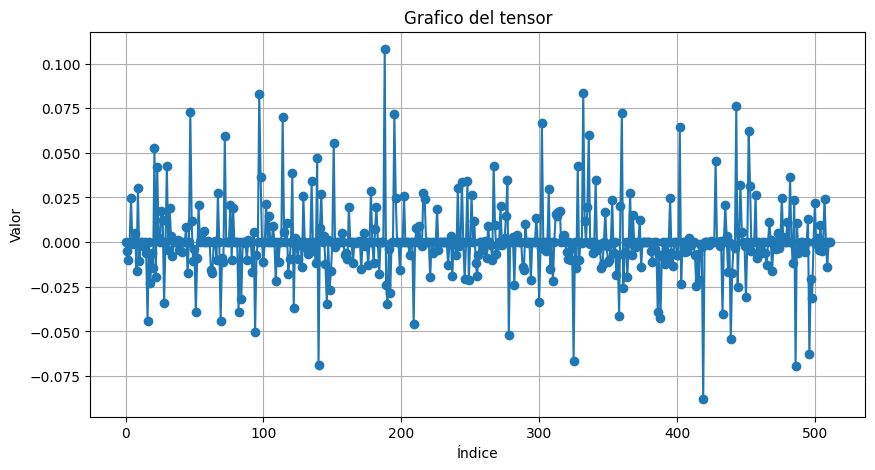

In [217]:
import matplotlib.pyplot as plt
datos = datos = [tensor.item() for tensor in dot_products]

# Crear un arreglo para los índices
indices = range(len(datos))

# Graficar los datos
plt.figure(figsize=(10, 5))
plt.plot(indices, datos, marker='o', linestyle='-')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Grafico del tensor')
plt.grid(True)
plt.show()

In [187]:
estado_fase_1 = torch.load('Fase_1.pth')

In [220]:
estado_fase_1 = torch.load('Fase_1.pth')
vector = embeddings_7[100][0] # torch.Size([1, 512])
row_7 = estado_fase_1["linear_relu_stack.4.weight"][7] # torch.Size([10, 512])
dot_products =  save_dot_products(vector, row_7)
Y = topk_indices(dot_products)

Índices de los 100 productos más altos:
tensor([188,  47, 382, 151, 402, 447, 443, 104, 114, 336,  97, 409,  30, 195,
         21, 302, 366, 248, 360,  44, 428, 485, 439, 452,  26, 313, 332, 121,
        267,  53, 277, 123,  78, 341, 216,  72,  51, 460, 307, 190,  23, 457,
         16, 196, 136,  76, 139, 477, 147, 107, 500, 244, 445, 178, 353, 487,
        476, 162, 367, 507, 509, 359,  98, 253, 453, 327, 314, 495, 146, 206,
        482,   4,   9, 142, 288, 217, 238,  94,   7, 419, 102, 486, 328, 132,
        182,  67, 140, 395, 425, 272,  52, 415, 251, 315, 458, 171,  20, 348,
        317, 454])


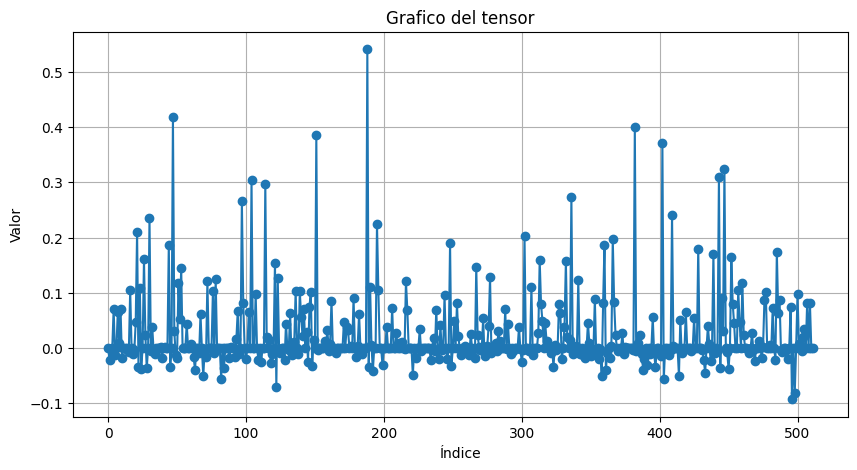

In [221]:
import matplotlib.pyplot as plt
datos = datos = [tensor.item() for tensor in dot_products]

# Crear un arreglo para los índices
indices = range(len(datos))

# Graficar los datos
plt.figure(figsize=(10, 5))
plt.plot(indices, datos, marker='o', linestyle='-')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Grafico del tensor')
plt.grid(True)
plt.show()

In [222]:
# Convertir los tensores en conjuntos
set1 = set(X.tolist())
set2 = set(Y.tolist())

# Calcular la intersección de los conjuntos
interseccion = set1.intersection(set2)

# Obtener la cantidad de números que comparten
cantidad_compartidos = len(interseccion)

# Imprimir el resultado
print("Cantidad de números que comparten los dos tensores:", cantidad_compartidos)

Cantidad de números que comparten los dos tensores: 68


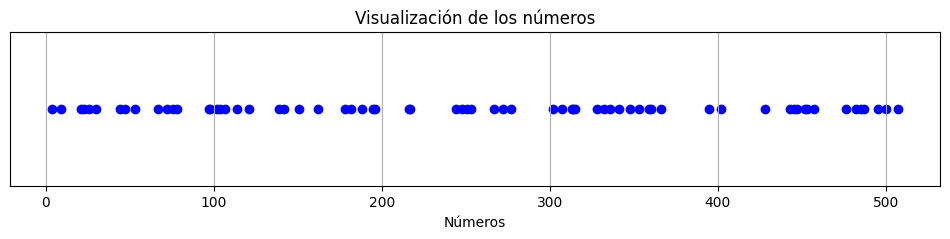

In [223]:
import matplotlib.pyplot as plt

# Definir el conjunto de números
numeros = interseccion

# Crear una lista de coordenadas x para cada número
coordenadas_x = list(numeros)

# Crear una lista de y con ceros para mantener los puntos en una línea
coordenadas_y = [0] * len(numeros)

# Graficar los números
plt.figure(figsize=(12, 2))
plt.scatter(coordenadas_x, coordenadas_y, marker='o', color='blue')
plt.xlabel('Números')
plt.title('Visualización de los números')
plt.yticks([])  # Eliminar marcas en el eje y
plt.grid(axis='x')  # Mostrar una cuadrícula en el eje x
plt.show()


### Veamos que pasa con otra clase

In [227]:
eval_data = torchvision.datasets.MNIST(
    root="../data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
# Conjunto de evaluación
eval_indices_to_3 = [i for i in range(len(eval_data)) if eval_data.targets[i] == 3]

eval_to_3 = torch.utils.data.Subset(eval_data, eval_indices_to_3)
eval_to_3_dataloader = DataLoader(eval_to_3, batch_size, shuffle=True)

In [228]:
embeddings_3 =  extractor(eval_to_3_dataloader, model)

In [229]:
for select in range(20):
    print(select,torch.norm(embeddings_3[select][0]) ,embeddings_3[select][2],torch.argmax(embeddings_3[select][1]))

0 tensor(11.5100) tensor([3]) tensor(8)
1 tensor(14.4088) tensor([3]) tensor(3)
2 tensor(15.7305) tensor([3]) tensor(3)
3 tensor(11.6014) tensor([3]) tensor(3)
4 tensor(19.9252) tensor([3]) tensor(3)
5 tensor(16.2749) tensor([3]) tensor(3)
6 tensor(9.7036) tensor([3]) tensor(3)
7 tensor(14.5444) tensor([3]) tensor(8)
8 tensor(14.3388) tensor([3]) tensor(3)
9 tensor(13.4876) tensor([3]) tensor(3)
10 tensor(12.5208) tensor([3]) tensor(3)
11 tensor(13.4001) tensor([3]) tensor(3)
12 tensor(18.3830) tensor([3]) tensor(3)
13 tensor(14.7502) tensor([3]) tensor(3)
14 tensor(25.2103) tensor([3]) tensor(6)
15 tensor(21.2548) tensor([3]) tensor(3)
16 tensor(15.7732) tensor([3]) tensor(3)
17 tensor(13.0883) tensor([3]) tensor(3)
18 tensor(15.3702) tensor([3]) tensor(3)
19 tensor(10.5725) tensor([3]) tensor(3)


In [235]:
from pprint import pprint
estado_fase_1 = torch.load('Fase_1.pth')

In [237]:
vector = embeddings_3[100][0] # torch.Size([1, 512])
row_3 = estado_fase_1["linear_relu_stack.4.weight"][3] # torch.Size([10, 512])
dot_products =  save_dot_products(vector, row_3)
X =  topk_indices(dot_products)

Índices de los 100 productos más altos:
tensor([496,  53, 425, 439, 123, 211, 433, 327, 361, 414, 114, 277,  47,  28,
        358, 199,  69, 159, 485, 267, 348,  67, 336, 145, 382, 184, 351, 469,
        266, 323, 240, 128, 151,  13, 386, 121, 364, 238, 402,  52, 480, 444,
        360, 258,  63, 350, 416, 461, 505, 261,  30, 237, 147,  10,  20, 356,
        276, 249, 349, 278, 464,  76, 138, 160, 488, 347,  84, 228, 281, 408,
        244,   2, 256, 246, 282, 289, 436,  77, 339, 292, 176, 393, 215, 262,
        135,  36, 353, 216, 482, 359,  92, 233, 366,  95, 111, 109,  89, 270,
        192, 298])


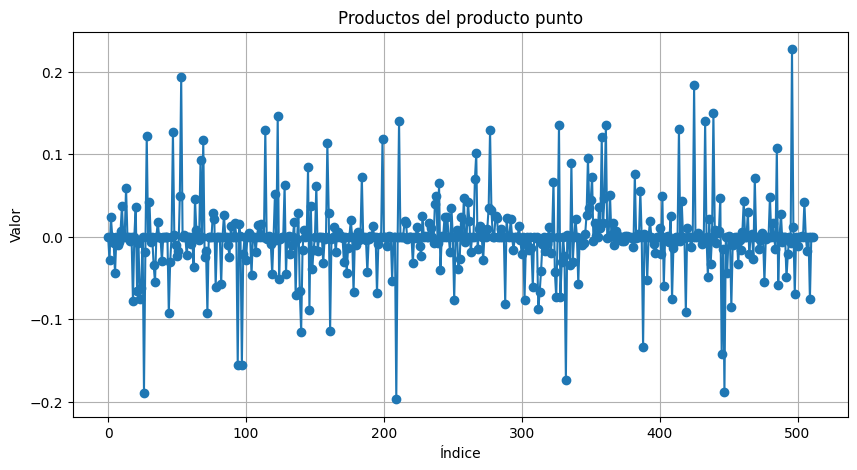

In [240]:
import matplotlib.pyplot as plt
datos = datos = [tensor.item() for tensor in dot_products]

# Crear un arreglo para los índices
indices = range(len(datos))

# Graficar los datos
plt.figure(figsize=(10, 5))
plt.plot(indices, datos, marker='o', linestyle='-')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Productos del producto punto')
plt.grid(True)
plt.show()

In [241]:
estado_fase_1 = torch.load('Fase_0.pth')
vector = embeddings_3[100][0] # torch.Size([1, 512])
row_3 = estado_fase_1["linear_relu_stack.4.weight"][3] # torch.Size([10, 512])
dot_products =  save_dot_products(vector, row_3)
Y = topk_indices(dot_products)

Índices de los 100 productos más altos:
tensor([496,  53, 114, 277,  47, 425, 439, 123, 433, 327, 358,  69, 151,  28,
        211, 382, 361, 402, 159, 414, 199, 485, 267, 121, 323, 469, 444, 128,
        348,  67, 336, 145, 184, 266, 351, 386, 360,  13, 240, 249,  63, 364,
         20, 461,  52, 278, 238,  30, 416,  84, 237, 480, 443,  10, 350, 440,
        147, 261, 353, 356, 505, 258, 135, 246, 349, 292,  51,  76, 192, 276,
        138, 160,  16, 256, 190, 339, 289, 244, 176, 488, 253, 464, 111, 216,
        281, 446, 188, 228, 474, 282,   2, 436, 487, 359, 104, 408, 347, 310,
        269, 366])


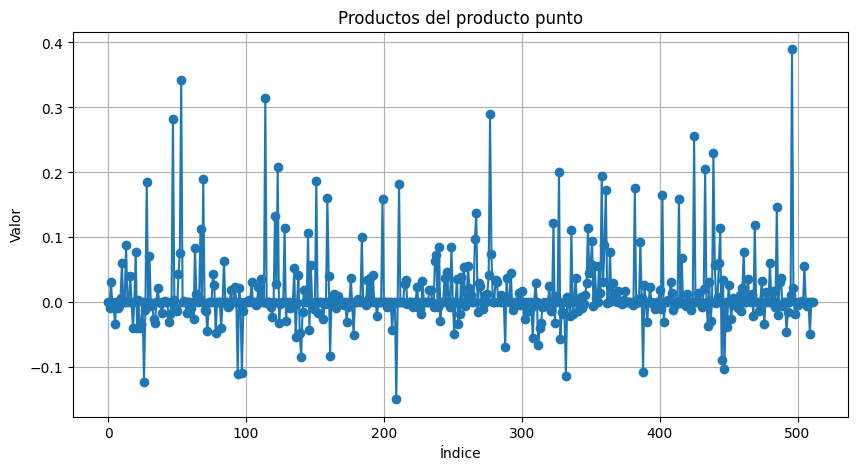

In [246]:
import matplotlib.pyplot as plt
datos = datos = [tensor.item() for tensor in dot_products]

# Crear un arreglo para los índices
indices = range(len(datos))

# Graficar los datos
plt.figure(figsize=(10, 5))
plt.plot(indices, datos, marker='o', linestyle='-')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Productos del producto punto')
plt.grid(True)
plt.show()

In [242]:
# Convertir los tensores en conjuntos
set1 = set(X.tolist())
set2 = set(Y.tolist())

# Calcular la intersección de los conjuntos
interseccion = set1.intersection(set2)

# Obtener la cantidad de números que comparten
cantidad_compartidos = len(interseccion)

# Imprimir el resultado
print("Cantidad de números que comparten los dos tensores:", cantidad_compartidos)

Cantidad de números que comparten los dos tensores: 87


Coincideron los 85 indices con las puntuaciones mas altas. 

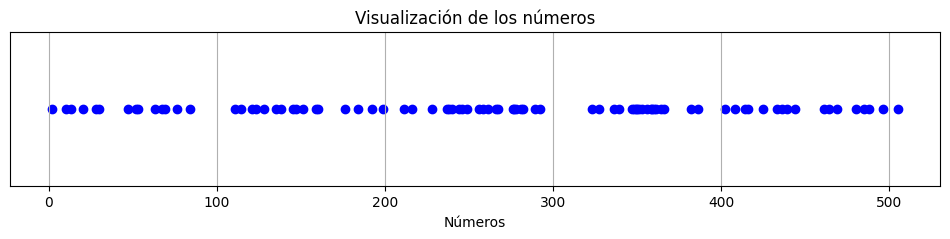

In [244]:
import matplotlib.pyplot as plt

# Definir el conjunto de números
numeros = interseccion

# Crear una lista de coordenadas x para cada número
coordenadas_x = list(numeros)

# Crear una lista de y con ceros para mantener los puntos en una línea
coordenadas_y = [0] * len(numeros)

# Graficar los números
plt.figure(figsize=(12, 2))
plt.scatter(coordenadas_x, coordenadas_y, marker='o', color='blue')
plt.xlabel('Números')
plt.title('Visualización de los números')
plt.yticks([])  # Eliminar marcas en el eje y
plt.grid(axis='x')  # Mostrar una cuadrícula en el eje x
plt.show()
